In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
import keras
import keras.backend as Kback
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.layers.core import Activation
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

model_path = 'RNN_regression_PCA_FD1.h5'

import random
random.seed(123)


Using TensorFlow backend.


In [2]:
from math import e

In [3]:
#######
#Data ingestion & processing
######

train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD001.txt")
RUL_real = RUL_test
#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for both sensor variables and operational conditions

train_df['Cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_df[cols_normalize])
norm_train_df = pd.DataFrame(scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# Principal Component Analysis Dimensionality Reduction

pca = PCA(.95)

pca.fit(norm_train_df)
transformed_train = pca.transform(scaled_train)

df_transformed_train = pd.DataFrame(transformed_train, index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(df_transformed_train)
train_df = join_df.reindex()


# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']


# Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

train_df['UL_30'] = np.where(train_df['RUL'] <= 30, 1, 0)
train_df['UL_50'] = np.where(train_df['RUL'] <= 50, 1, 0)
train_df['UL_75'] = np.where(train_df['RUL'] <= 75, 1, 0)




In [4]:
def complete (test_df, seq_length):

    for i in test_df['Unit']:

        test = test_df[test_df['Unit']==i]

        if (test['Cycle'].max()<seq_length):

            print("He entrado en ", i)

            n_cycles = 50 - test['Cycle'].max()

            new_values = np.zeros((n_cycles.astype(int),test_df.shape[1]))
            new_values[:,2:] = test.iloc[:,2:].mean(axis = 0).to_numpy()
            new_values[:,0] = i
            new_values[:,1] = range(test['Cycle'].max().astype(int)+1, 51)

            new_values = pd.DataFrame(new_values, columns = test_df.columns)

            test = pd.concat([test,new_values]).reset_index()

            test = test.drop(test.columns[0],axis=1)

            #print(test.head())

            test_df = pd.concat([test_df[test_df['Unit']<i],test,test_df[test_df['Unit']>i]]).reset_index()

            test_df = test_df.drop(test_df.columns[0],axis = 1)


    return test_df

            


In [5]:
# Data will be input into the RNN in windows with a certain size
sequence_length = 50

test_df = complete(test_df, sequence_length)

test_df.head(50)

He entrado en  1
He entrado en  2
He entrado en  14
He entrado en  22
He entrado en  25
He entrado en  39
He entrado en  85


,Unit,Cycle,OP1,OP2,OP3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1.0,1.0,0.002300,0.000300,100.0,518.67,643.020000,1585.290000,1398.210000,14.62,...,521.720000,2388.030000,8125.550000,8.405200,0.03,392.000000,2388.0,100.0,38.860000,23.373500
1,1.0,2.0,-0.002700,-0.000300,100.0,518.67,641.710000,1588.450000,1395.420000,14.62,...,522.160000,2388.060000,8139.620000,8.380300,0.03,393.000000,2388.0,100.0,39.020000,23.391600
2,1.0,3.0,0.000300,0.000100,100.0,518.67,642.460000,1586.940000,1401.340000,14.62,...,521.970000,2388.030000,8130.100000,8.444100,0.03,393.000000,2388.0,100.0,39.080000,23.416600
3,1.0,4.0,0.004200,0.000000,100.0,518.67,642.440000,1584.120000,1406.420000,14.62,...,521.380000,2388.050000,8132.900000,8.391700,0.03,391.000000,2388.0,100.0,39.000000,23.373700
4,1.0,5.0,0.001400,0.000000,100.0,518.67,642.510000,1587.190000,1401.920000,14.62,...,522.150000,2388.030000,8129.540000,8.403100,0.03,390.000000,2388.0,100.0,38.990000,23.413000
5,1.0,6.0,0.001200,0.000300,100.0,518.67,642.110000,1579.120000,1395.130000,14.62,...,521.920000,2388.080000,8127.460000,8.423800,0.03,392.000000,2388.0,100.0,38.910000,23.346700
6,1.0,7.0,-0.000000,0.000200,100.0,518.67,642.110000,1583.340000,1404.840000,14.62,...,522.010000,2388.060000,8134.970000,8.391400,0.03,391.000000,2388.0,100.0,38.850000,23.395200
7,1.0,8.0,0.000600,-0.000000,100.0,518.67,642.540000,1580.890000,1400.890000,14.62,...,522.090000,2388.060000,8125.930000,8.421300,0.03,393.000000,2388.0,100.0,39.050000,23.322400
8,1.0,9.0,-0.003600,0.000000,100.0,518.67,641.880000,1593.290000,1412.280000,14.62,...,522.030000,2388.050000,8134.150000,8.435300,0.03,391.000000,2388.0,100.0,39.100000,23.452100
9,1.0,10.0,-0.002500,-0.000100,100.0,518.67,642.070000,1585.250000,1398.640000,14.62,...,522.000000,2388.060000,8134.080000,8.409300,0.03,391.000000,2388.0,100.0,38.870000,23.382000


In [6]:
###TEST DATA SET###

# Data will be input into the RNN in windows with a certain size
sequence_length = 50

test_df = complete(test_df, sequence_length)

#Normalize data
test_df['Cycle_norm'] = test_df['Cycle']
norm_test_df = pd.DataFrame(scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

print(norm_train_df.shape,norm_test_df.shape)

#Principal Component Analysis Dimensionality Reduction

transformed_test = pca.transform(norm_test_df)

df_transformed_test = pd.DataFrame(transformed_test, index = test_df.index)

join_df = test_df[test_df.columns.difference(cols_normalize)].join(df_transformed_test)
test_df = join_df.reindex()

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)

#Data labeling - UL_30 - UL_50 - UL_75 --> Labeling to predict if the turbine is going to fail on les than 30, 50 or 75 cycles

test_df['UL_30'] = np.where(test_df['RUL'] <= 30, 1, 0)
test_df['UL_50'] = np.where(test_df['RUL'] <= 50, 1, 0)
test_df['UL_75'] = np.where(test_df['RUL'] <= 75, 1, 0)






(20631, 25) (13162, 25)


In [8]:
test_df.head()

,Cycle,Unit,0,1,2,3,4,5,6,7,8,9,10,11,12,max,RUL,UL_30,UL_50,UL_75
0,1.0,1.0,-2.780692,-0.925266,1.479852,0.094848,-0.087867,0.798340,0.542279,-0.864628,0.753706,-0.385578,-0.614984,-0.430257,-0.500874,162.0,161.0,0,0,0
1,2.0,1.0,-3.829730,-0.137303,-1.522414,-0.398876,-0.468548,0.746025,-0.403726,1.249216,-0.190006,0.214643,-0.494211,0.203468,0.515518,162.0,160.0,0,0,0
2,3.0,1.0,-2.634618,-0.537807,0.382419,-0.181025,-0.181669,0.906453,0.271569,0.367783,0.537981,-0.069263,1.013366,-0.194779,-0.055685,162.0,159.0,0,0,0
3,4.0,1.0,-3.134927,-0.926062,1.323615,1.324021,-0.577763,0.467642,0.171161,-0.680239,-0.050309,0.231176,-0.173163,0.695055,0.166781,162.0,158.0,0,0,0
4,5.0,1.0,-3.757458,-0.829053,0.475399,0.379503,-0.405009,0.534661,-0.464139,-1.198824,0.023667,-0.129723,0.042038,0.120429,-0.145828,162.0,157.0,0,0,0


In [ ]:
train_df.iloc[:,2:-5].head()

In [7]:
#####
#Data formatting#
####

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

sequence_cols = list(train_df.columns[2:-5].values)
#sequence_cols.extend(["Cycle_norm"])

#val=list(gen_sequence(train_df[train_df['Unit']==1], sequence_length, sequence_cols))

seq_gen = (list(gen_sequence(train_df[train_df['Unit']==id], sequence_length, sequence_cols)) 
           for id in train_df['Unit'].unique())


# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['Unit']==id], sequence_length, ['RUL']) 
             for id in train_df['Unit'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(15631, 50, 13)


(15631, 1)

In [8]:
#label_array[label_array >145] = 145

In [9]:
def r2_keras(y_true, y_pred):
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    score_vec = np.zeros(len(y_true))

    for i in range(len(d)): 
        if d[i]<0:
            score_vec[i] = (e**(-d[i]/a1) - 1)
            score += score_vec[i]
        else : 
            score_vec[i] = (e**(d[i]/a2) - 1)
            score += score_vec[i]

    fig_hist = plt.figure(figsize=(10,5))
    plt.hist(score_vec, color = "#3f729a" )
    hist_data, _, _ = plt.hist(score_vec, color = "#3f729a" )
    print(hist_data)
    plt.ylabel("Frequency")
    plt.xlabel("Score")

    score_low = 0
    score_high = 0

    for i in range(len(d)):

        if score_vec[i] < 50:
            score_low += score_vec[i]
        else:
            score_high += score_vec[i]

    

    print(score_low, score_high)
    print(score_low/(score_low + score_high))

    plt.figure()
    plt.plot(range(100),score_vec)

    return score






In [10]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

RNN_model = Sequential()
RNN_model.add(LSTM(
    input_shape = (sequence_length, nb_features),
    units = 50,
    return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = True))
RNN_model.add(Dropout(0.2))
RNN_model.add(LSTM(units = 25, return_sequences = False))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(units = nb_out))
RNN_model.add(Activation("linear"))
RNN_model.compile(loss = 'mean_squared_error', optimizer = 'rmsprop', metrics = ['mae', r2_keras])

print(RNN_model.summary())

result = RNN_model.fit(seq_array, label_array, epochs = 100, batch_size = 100, validation_split = 0.05, verbose = 1,
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=10, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)]
    )
print(result.history.keys())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            12800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 25)            7600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 25)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

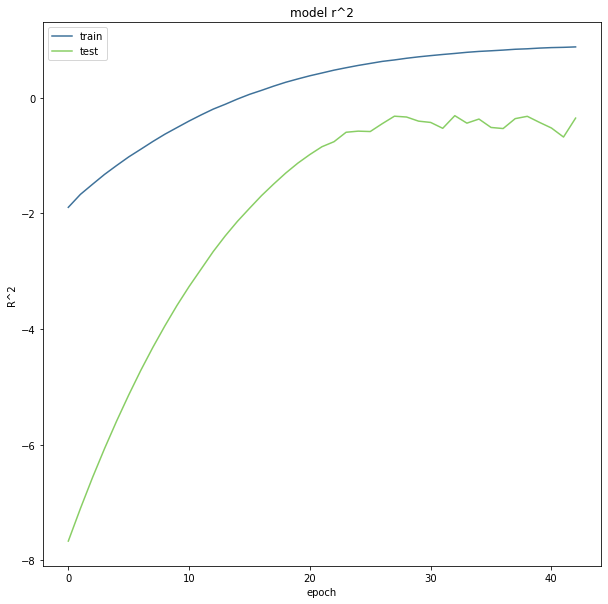

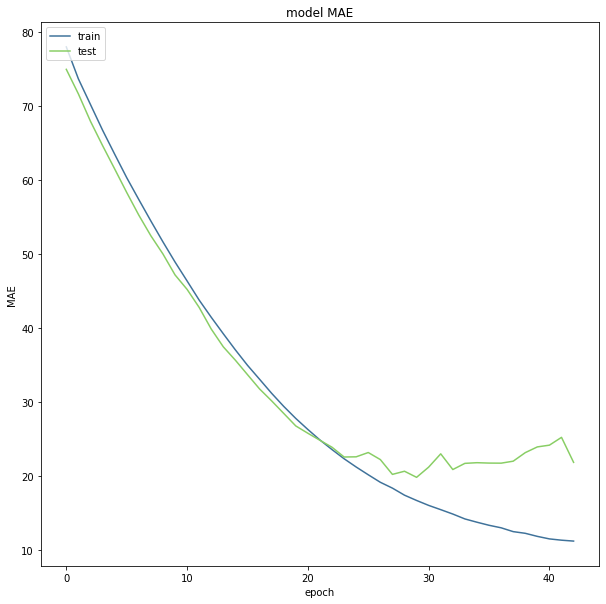

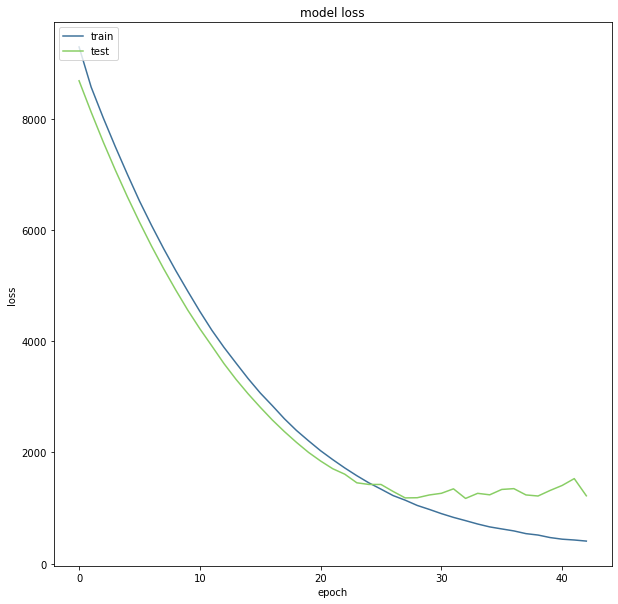

In [11]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")


In [12]:
# training metrics
scores = RNN_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = RNN_model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

#test_set = pd.DataFrame(y_pred)
#test_set.to_csv('submit_train.csv', index = None)

15631/15631 [==============================] - 6s 364us/step

MAE: 8.886099815368652

R^2: 0.9051319360733032
15631/15631 [==============================] - 6s 360us/step



MAE: 12.322691917419434

R^2: 0.8279203176498413


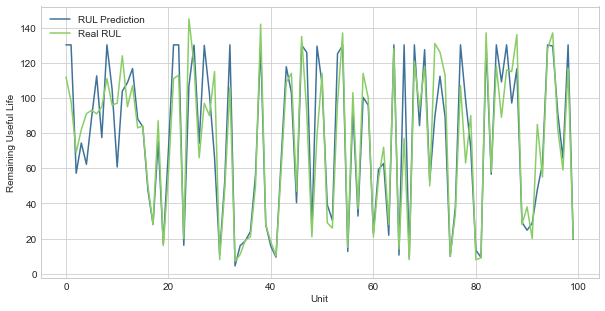

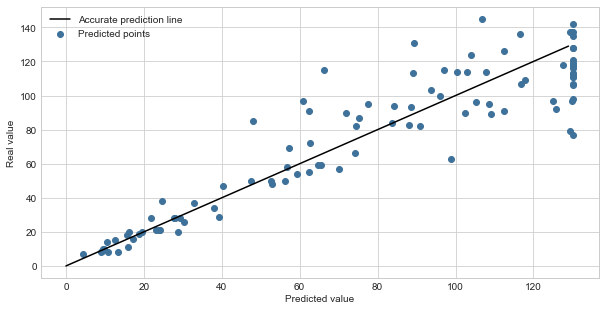

In [13]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['Unit']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['Unit'].unique() if len(test_df[test_df['Unit']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['Unit']==id]) >= sequence_length for id in test_df['Unit'].unique()]
label_array_test_last = test_df.groupby('Unit')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="#3f729a")
    plt.plot(y_true_test, color="#89ce65")
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('Unit')
    plt.legend(['RUL Prediction', 'Real RUL'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()

[91.  2.  1.  3.  2.  0.  0.  0.  0.  1.]
372.9380476474762 251.1536979675293
0.5975692680888894
The computed challenge score is: S = 624.0917456150055


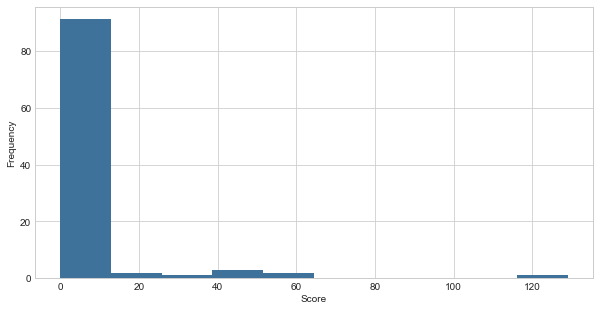

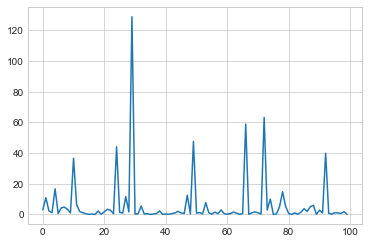

In [14]:
print("The computed challenge score is: S = {}".format(Computed_Score(y_true_test, y_pred_test)))

The model score is: 624.0918148654846
The model accuracy is: 62.0
The model MAE is: 12.32269287109375
The model MSE is : 295.95728515625
The model Mean Absolute Percentage Error (MAPE) is: 17.093761444091797
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 593.6720754336669


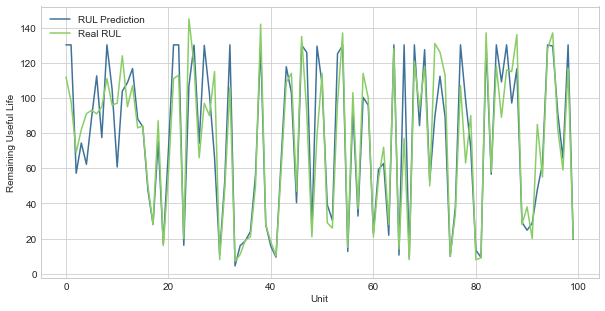

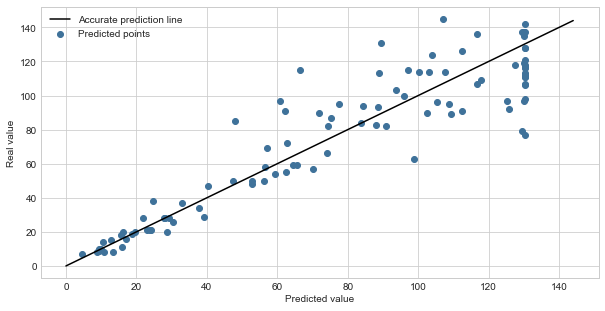

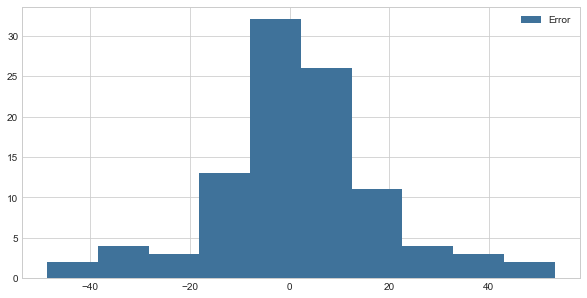

In [15]:
from Perform_function import perform_func 
_, _, _, _, _, _ = perform_func(y_pred_test, y_true_test, test_df.groupby('Unit').max()['Cycle'].to_numpy())

[91.  2.  1.  3.  2.  0.  0.  0.  0.  1.]
372.9380476474762 251.1536979675293
0.5975692680888894


624.0917456150055

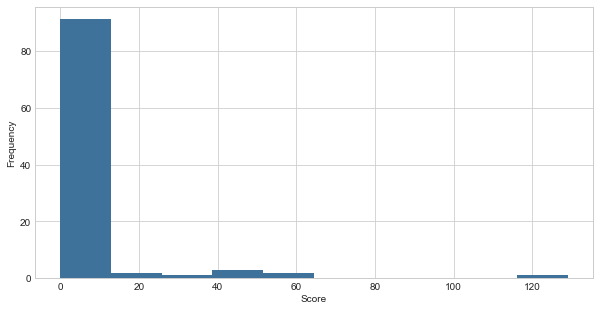

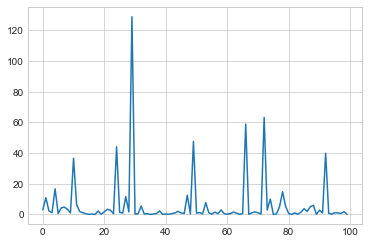

In [16]:
Computed_Score(y_true_test, y_pred_test)

In [52]:
test_df.head()

,Cycle,Unit,0,1,2,3,4,5,6,7,8,9,10,11,12,max,RUL,UL_30,UL_50,UL_75
0,1.0,1.0,-2.780692,-0.925266,1.479852,0.094848,-0.087867,0.798340,0.542279,-0.864628,0.753706,-0.385578,-0.614984,-0.430257,-0.500874,162.0,161.0,0,0,0
1,2.0,1.0,-3.829730,-0.137303,-1.522414,-0.398876,-0.468548,0.746025,-0.403726,1.249216,-0.190006,0.214643,-0.494211,0.203468,0.515518,162.0,160.0,0,0,0
2,3.0,1.0,-2.634618,-0.537807,0.382419,-0.181025,-0.181669,0.906453,0.271569,0.367783,0.537981,-0.069263,1.013366,-0.194779,-0.055685,162.0,159.0,0,0,0
3,4.0,1.0,-3.134927,-0.926062,1.323615,1.324021,-0.577763,0.467642,0.171161,-0.680239,-0.050309,0.231176,-0.173163,0.695055,0.166781,162.0,158.0,0,0,0
4,5.0,1.0,-3.757458,-0.829053,0.475399,0.379503,-0.405009,0.534661,-0.464139,-1.198824,0.023667,-0.129723,0.042038,0.120429,-0.145828,162.0,157.0,0,0,0


In [17]:
test_proof = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
                for id in test_df['Unit'].unique()]).reset_index(drop = True)

error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_proof[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] > 140) , 'Group_RUL'] = 8

In [18]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped

,Unit,Cycle,RUL,error,Group_RUL
Group,,,,,
3,35.833333,51.583333,116.333333,18.082306,6.333333
4,58.000000,72.727273,108.181818,19.833290,5.727273
5,62.857143,92.285714,113.857143,17.943039,6.000000
6,45.571429,108.571429,97.000000,16.740950,5.428571
7,50.388889,129.888889,59.611111,8.260777,3.444444
8,51.466667,177.755556,53.711111,9.014078,3.088889


In [19]:
error_grouped_RUL

,Unit,Cycle,RUL,error,Group
Group_RUL,,,,,
1,55.250000,173.125000,13.312500,2.517782,7.812500
2,57.500000,174.000000,28.250000,4.300103,7.750000
3,55.181818,153.636364,53.363636,5.660075,7.636364
4,48.166667,111.166667,71.000000,28.145903,6.000000
5,34.590909,133.045455,91.272727,17.909670,6.590909
6,49.850000,85.350000,112.600000,16.533972,4.700000
7,68.909091,110.272727,130.909091,12.242830,5.454545
8,32.000000,50.000000,143.500000,24.941978,3.000000


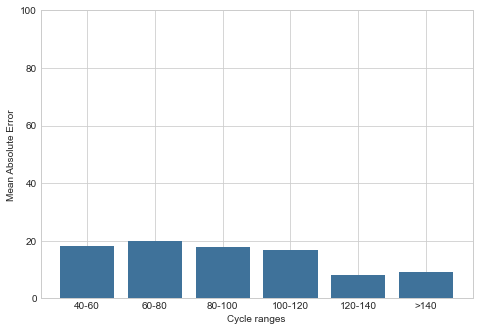

In [20]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,100)
plt.show()

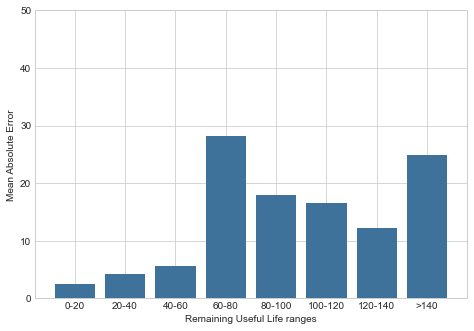

In [21]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0,50)
plt.show()

In [22]:
train_predictions = RNN_model.predict(seq_array)
train_predictions.shape

(15631, 1)

In [23]:
train_df.shape

v1 = train_df.loc[train_df['Unit']==1,'Cycle'].max() + 



SyntaxError: invalid syntax (<ipython-input-23-6a383692ff19>, line 3)

In [26]:
train_df['RUL_predict'] = 0
indice_retransf = 0
for i in train_df['Unit'].unique():

    print(i)

    max_indice = train_df.loc[train_df['Unit']==i,'Cycle'].max() + indice_retransf -50

    print()

    print(train_df.loc[(train_df['Unit']==i)&(train_df['Cycle']>50), 'RUL_predict'].shape)
    print(train_predictions[indice_retransf:max_indice,0].shape)


    train_df.loc[(train_df['Unit']==i)&(train_df['Cycle']>50), 'RUL_predict'] = train_predictions[indice_retransf:max_indice,0]

    indice_retransf += train_df.loc[train_df['Unit']==i,'Cycle'].max() - 50

1

(142,)
(142,)
2

(237,)
(237,)
3

(129,)
(129,)
4

(139,)
(139,)
5

(219,)
(219,)
6

(138,)
(138,)
7

(209,)
(209,)
8

(100,)
(100,)
9

(151,)
(151,)
10

(172,)
(172,)
11

(190,)
(190,)
12

(120,)
(120,)
13

(113,)
(113,)
14

(130,)
(130,)
15

(157,)
(157,)
16

(159,)
(159,)
17

(226,)
(226,)
18

(145,)
(145,)
19

(108,)
(108,)
20

(184,)
(184,)
21

(145,)
(145,)
22

(152,)
(152,)
23

(118,)
(118,)
24

(97,)
(97,)
25

(180,)
(180,)
26

(149,)
(149,)
27

(106,)
(106,)
28

(115,)
(115,)
29

(113,)
(113,)
30

(144,)
(144,)
31

(184,)
(184,)
32

(141,)
(141,)
33

(150,)
(150,)
34

(145,)
(145,)
35

(131,)
(131,)
36

(108,)
(108,)
37

(120,)
(120,)
38

(144,)
(144,)
39

(78,)
(78,)
40

(138,)
(138,)
41

(166,)
(166,)
42

(146,)
(146,)
43

(157,)
(157,)
44

(142,)
(142,)
45

(108,)
(108,)
46

(206,)
(206,)
47

(164,)
(164,)
48

(181,)
(181,)
49

(165,)
(165,)
50

(148,)
(148,)
51

(163,)
(163,)
52

(163,)
(163,)
53

(145,)
(145,)
54

(207,)
(207,)
55

(143,)
(143,)
56

(225,)
(225,)
57

(

In [29]:
train_df.loc[train_df['Cycle']<=50, 'RUL_predict'] = 145

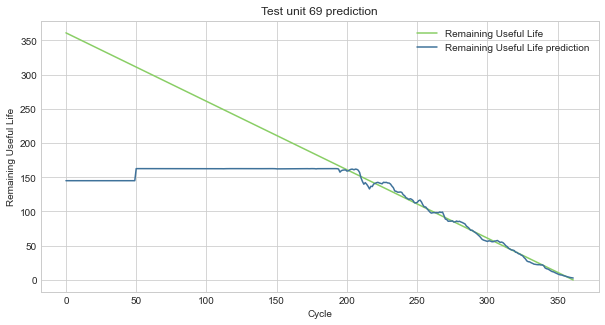

In [30]:
unit = 69

#train_df['RUL_tuned']=train_df['RUL']
#train_df.loc[train_df['RUL']>145,'RUL_tuned'] = 145
#train_df.loc[train_df['Cycle']<=50,'RUL_predict'] = 145

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")

#ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_tuned'], color = "#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
#ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 69 prediction")

ax.legend()

